# Creating comet models

In [1]:
import os, sys
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/stella/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/scripts/')
import numpy as np
from utils import *
import build_synthetic_set as models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman 
import warnings

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


### Generate the models

In [2]:
files = glob('../data/eleanor/s0007/*.fits', recursive=True)
random.shuffle(files)

In [3]:
files[0]

'../data/eleanor/s0007/hlsp_gsfc-eleanor-lite_tess_ffi_s0007-0000000147851219_tess_v1.0_lc.fits'

### Create models

In [4]:
folder = '../eleanor-lite-models' # do not add the dash after folder name here as it is done in the loop for saving files
figs = '../eleanor-lite-plots'

In [5]:
def calculate_timestep(table):
    """
    Function: Calculates the median value of the time differences between data points in a given table. 
    Provides an estimate of the timestep (or time delta) between consecutive data points.

    Parameters:
    :table (array or pandas.DataFrame): The input table containing time-series data.

    Returns:
    :dt (float): The estimated time interval or timestep between consecutive data points."""

    try:
        dt = [ table[i+1][0] - table[i][0] for i in range(len(table)-1) ] # calculates difference between (ith+1) - (ith) point 
        dt.sort()
        return dt[int(len(dt)/2)] # median of them.
    except:
        return np.median(np.diff(table['time'])) ## change this to account for any time column names

    

def clean_data(table):
    """
    Function: Interpolating missing data points, ensuring equal time gaps between points. 
    Returns five numpy arrays: time, flux, quality, real, and flux_error. Real is 0 if data point interpolated, 1 otherwise.

    Parameters:
    :table (astropy.table.table): The input table containing time-series data.
    
    Returns:
    :time (numpy.ndarray): An array of timestamps for each data point, including the interpolated points.
    :flux (numpy.ndarray): An array of flux values for each data point, including the interpolated points.
    :quality (numpy.ndarray): An array indicating the quality of each data point, including the interpolated points.
    :real (numpy.ndarray): An array indicating whether each data point is real (1) or interpolated (0).
    :flux_error (numpy.ndarray): An array of flux error values for each data point, including the interpolated points."""


    time = []
    flux = []
    quality = []
    real = []
    flux_error = []
    timestep = calculate_timestep(table)


    ### this scale factor ensures that you can use any cadence of lightcurves. 48 cadences = 1 day.
    factor = ((1/48)/timestep)

    for row in table:
        ti, fi, qi, fei = row

        if len(time) > 0:
            steps = int(round( (ti - time[-1])/timestep * factor)) # (y2-y1)/(x2-x1)
            if steps > 1:
                fluxstep = (fi - flux[-1])/steps
                fluxerror_step = (fei - flux_error[-1])/steps

                # For small gaps, pretend interpolated data is real.
                if steps > 4:
                    set_real=0
                else:
                    set_real=1

                for _ in range(steps-1):
                    time.append(timestep + time[-1])
                    flux.append(fluxstep + flux[-1])
                    flux_error.append(fluxerror_step + flux_error[-1])

                    quality.append(0)
                    real.append(set_real)
        time.append(ti)
        flux.append(fi)
        quality.append(qi)
        real.append(1)
        flux_error.append(fei)

    return [np.array(x) for x in [time,flux,quality,real,flux_error]]

In [6]:
# os.makedirs(folder, exist_ok=True)
# os.makedirs(figs, exist_ok=True)
# fails = []
# times = []
# rmsfails = []
# ticid = []

# min_snr = 5
# max_snr = 20

# for i in tqdm(files[0:1000]):
#     try:

#         ### READ IN LIGHTCURVE
#         lc, lc_info = import_lightcurve(i, drop_bad_points=True)
#         sector = f"{lc_info['sector']:02d}"

#         ### FLATTEN THE ORIGINAL LIGHTCURVE
#         flat_flux = wotan.flatten(lc['TIME'], lc['PCA_FLUX'], method='median', window_length=1)

#         ### GET RMS OF FLATTENED ORIGINAL LIGHTCURVE
#         rms = np.nanstd(flat_flux)
#         if np.isnan(rms):
#             rmsfails.append(rms)
#             continue

#         ### IDENTIFY LARGE GAPS IN ORIGINAL LIGHTCURVE
        
#         diff = np.diff(lc['TIME'])
#         large_gaps_indices = np.where(diff > 1)[0]

        
#         ### CREATE COPY OF LIGHTCURVE
#         lcc = lc.copy()
#         lcc = lcc[lcc['QUALITY'] == 0]
#         tic = lc_info['TIC_ID']
#         lcc = lcc['TIME','PCA_FLUX','QUALITY','FLUX_ERR']
        
#         ### INTERPOLATE THE COPIED LIGHTCURVE 
#         time, flux, quality, real, flux_error = clean_data(lcc)


#         ### CHOOSE RANDOM SNR VALUE 
#         random_snr = np.random.uniform(min_snr, max_snr)
#         A = rms * random_snr

#         # INITIALISE FLAG TO FIND IF TIME IS GOOD TO INJECT IN (THIS IS BASED ON THE TIMES OF THE ORIGINAL LIGHTCURVE)
#         valid_time_found = False

#         while not valid_time_found:
#             t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])

#             for index in large_gaps_indices:
#                 start_time = lc['TIME'][index] - 1
#                 end_time = lc['TIME'][index + 1] + 1
#                 if start_time <= t0 <= end_time:
#                     break
#                 elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 2:
#                     break
#                 elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 2:
#                     break
#                 elif t0 <= lc['TIME'][0] + 2:
#                     break
#                 elif t0 >= lc['TIME'][-1] - 2:
#                     break
#             else:
#                 valid_time_found = True

#         ### CREATE MODEL BASED ON THE INTERPOLATED LIGHTCURVE TIME ARRAY
#         model = 1 - models.comet_curve(time[real == 1], A, t0)

#         ### CHECK INETRPOLATION WORKED PROPERLY
#         #array = lambda arr: np.all(np.round(arr, 2) == np.round(arr[0], 2))
#         #print(array(np.diff(time)))

#         ### INJECT MODEL INTO INTERPOLATED LIGHTCURVE
#         f = model * (flux[real == 1]/np.nanmedian(flux[real == 1])) # (lcc['PCA_FLUX'] / np.nanmedian(lcc['PCA_FLUX']))
        
#         # plt.scatter(lc['TIME'], lc['PCA_FLUX'] / np.nanmedian(lc['PCA_FLUX']), zorder=6)
#         # plt.scatter(lcc['TIME'], lcc['PCA_FLUX'] / np.nanmedian(lcc['PCA_FLUX'])-0.05)
#         # #plt.scatter(lcc['TIME'][small_gap_bad_indices], lcc['PCA_FLUX'][small_gap_bad_indices] / np.nanmedian(lcc['PCA_FLUX'])-0.05, color='black', marker='x', zorder=7,label='interpolated points')
#         # plt.scatter(lcc['TIME'], flux-0.1)
#         # plt.legend()
#         # plt.show()

    
#         ### GET FLUX ERRORS FOR INTERPOLATED LIGHTCURVE  
#         fluxerror = np.array(flux_error[real == 1]/np.nanmedian(flux)) 

#         ### APPEND TIMES AND TIC ID FOR THE CATALOG
#         times.append(t0)
#         ticid.append(tic)
        
        
#         # fig,ax = plt.subplots(1,2,figsize=(15,4))        

#         # min_idx = np.argmin(model)
#         # ax[0].plot(time[real==1][min_idx-84:min_idx+84], model[min_idx-84:min_idx+84])
#         # ax[1].scatter(lc['TIME'],lc['PCA_FLUX']/np.nanmedian(lc['PCA_FLUX']),s=5)
#         # ax[1].scatter(time[real==1],f-0.01,s=5,color='orange',label='interpolated lightcurve (steps < 2 points treated as real)')
#         # ax[1].scatter(time[real==1],(flux[real==1]/np.nanmedian(flux))-0.01,s=5,color='black',label='cleaned lightcurve')
#         # ax[1].scatter(time[real==0],(flux[real==0])/np.nanmedian(flux)-0.02,s=5,color='red',label='interpolated points')
#         # plt.legend(bbox_to_anchor=(1, 1))
#         # plt.savefig(f"{figs}/{lc_info['TIC_ID']}_sector{sector}-exoplanet.png",dpi=200,bbox_inches='tight')
#         # plt.close()

#         #assert len(time[real == 1]) == len(time), "Error: The lightcurve contains interpolated points."
#         #assert len(flux[real == 1]) == len(flux), "Error: The lightcurve contains interpolated points."

        
#         ### SAVE INTO NUMPY FOLDER
#         np.save(f"{folder}/{lc_info['TIC_ID']}_sector{sector}.npy", np.array([time[real==1], f, fluxerror]))
#         # for index in large_gaps_indices:
#         #     last_value_before_gap = lc['TIME'][index]
#         #     print(f"Last value before gap: {last_value_before_gap}")
#         # print(t0)
#     except TypeError as e:
#         fails.append(i)
#         print(f"Exception occurred for file {i}: {e}. Continuing...")
#         continue
# # print(f"models skipped for TICs {ticid}")

In [7]:
os.makedirs(folder, exist_ok=True)
os.makedirs(figs, exist_ok=True)
fails = []
times = []
rmsfails = []
ticid = []

min_snr = 3
max_snr = 20
window_size = 84  # Number of cadences representing the window size (3.5 days)

for i in tqdm(files[0:2020]):
    try:
        ### READ IN LIGHTCURVE
        lc, lc_info = import_lightcurve(i, drop_bad_points=True)
        sector = f"{lc_info['sector']:02d}"

        ### FLATTEN THE ORIGINAL LIGHTCURVE
        flat_flux = wotan.flatten(lc['TIME'], lc['PCA_FLUX'], method='median', window_length=1)

        ### GET RMS OF FLATTENED ORIGINAL LIGHTCURVE
        rms = np.nanstd(flat_flux)
        if np.isnan(rms):
            rmsfails.append(rms)
            continue

        ### IDENTIFY LARGE GAPS IN ORIGINAL LIGHTCURVE
        diff = np.diff(lc['TIME'])
        large_gaps_indices = np.where(diff > 1)[0]

        ### CREATE COPY OF LIGHTCURVE
        lcc = lc.copy()
        lcc = lcc[lcc['QUALITY'] == 0]
        tic = lc_info['TIC_ID']
        lcc = lcc['TIME', 'PCA_FLUX', 'QUALITY', 'FLUX_ERR']

        ### INTERPOLATE THE COPIED LIGHTCURVE
        time, flux, quality, real, flux_error = clean_data(lcc)

        ### CHOOSE RANDOM SNR VALUE
        random_snr = np.random.uniform(min_snr, max_snr)
        A = rms * random_snr

        # INITIALISE FLAG TO FIND IF TIME IS GOOD TO INJECT IN (THIS IS BASED ON THE TIMES OF THE ORIGINAL LIGHTCURVE)
        valid_time_found = False

        while not valid_time_found:
            t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])

            # Check if t0 avoids large gaps
            valid_t0 = False
            for index in large_gaps_indices:
                start_time = lc['TIME'][index] - 1
                end_time = lc['TIME'][index + 1] + 1
                if start_time <= t0 <= end_time:
                    break
                elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
                    break
                elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
                    break
                elif t0 <= lc['TIME'][0] + 1.5:
                    break
                elif t0 >= lc['TIME'][-1] - 1.5:
                    break
            else:
                valid_t0 = True

            if valid_t0:
                # Check if all data points within the window are non-interpolated
                window_start = np.argmin(np.abs(time - (t0 - window_size * np.median(np.diff(time)))))
                window_end = np.argmin(np.abs(time - (t0 + window_size * np.median(np.diff(time))))) + 1
                if np.all(real[window_start:window_end] == 1):
                    valid_time_found = True

        ### CREATE MODEL BASED ON THE INTERPOLATED LIGHTCURVE TIME ARRAY
        model = 1 - models.comet_curve(time, A, t0)

        ### INJECT MODEL INTO INTERPOLATED LIGHTCURVE
        f = model * (flux/np.nanmedian(flux))
        fluxerror = flux_error/flux

        ### APPEND TIMES AND TIC ID FOR THE CATALOG
        times.append(t0)
        ticid.append(tic)

        ### SAVE INTO NUMPY FOLDER
        np.save(f"{folder}/{lc_info['TIC_ID']}_sector{sector}.npy",np.array([time[real == 1], f[real == 1], fluxerror[real == 1], real[real == 1]]))
        #np.save(f"{folder}/{lc_info['TIC_ID']}_sector{sector}.npy", np.array([time, f, fluxerror, real]))

    except TypeError as e:
        fails.append(i)
        print(f"Exception occurred for file {i}: {e}. Continuing...")
        continue

 15%|█▊          | 304/2020 [00:09<00:49, 34.42it/s]/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|███████████| 2020/2020 [01:01<00:00, 33.09it/s]


---

### Converting non-model lightcurves to `.npy` arrays

Issue: no. of injected lightcurves must be more than test sample

In [8]:
# for i in tqdm(files[10000:20000]):
#     try:
#         lc, info = import_lightcurve(i)
#         tic = info['TICID']
    
#         fluxerror = np.array(lc['SAP_FLUX_ERR'] / np.nanmedian(lc['SAP_FLUX']))

#         time = np.array(lc['TIME'])
#         flux = np.array(lc['SAP_FLUX'] / np.nanmedian(lc['SAP_FLUX']))
#         np.save(f"../models/{info['TICID']}_sector28.npy", np.array([time, flux, fluxerror]))
#     except TypeError:
#         continue

## Loading comet models

In [9]:
comets =  glob('../eleanor-lite-models/*.npy')
comets[0:3]

['../eleanor-lite-models/172840198_sector07.npy',
 '../eleanor-lite-models/169911895_sector07.npy',
 '../eleanor-lite-models/153266683_sector07.npy']

### Sample plot of Full Lightcurves

In [10]:
# num_files_per_grid = 100

# for i in range(0, len(comets), num_files_per_grid):
#     batch_paths = comets[i:i+num_files_per_grid]
#     num_rows, num_cols = 10, 10
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

#     for j, path in enumerate(batch_paths):
#         file = np.load(path,allow_pickle=True)
#         time = file[0]
#         flux = file[1]/np.nanmedian(file[1])


        
#         # Extract the file ID from the path
#         file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]
        

#         row = j // num_cols
#         col = j % num_cols

#         axs[row, col].plot(time, flux)
#         axs[row, col].set_title(f'TIC {file_id}')

#     plt.tight_layout()
#     plt.show()
    

In [11]:
# num_files_per_grid = 25  # Since you want a 5x5 grid

# for i in range(0, len(comets), num_files_per_grid):
#     batch_paths = comets[i:i+num_files_per_grid]
#     num_rows, num_cols = 5, 5  # Set the number of rows and columns for the grid
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

#     for j, path in enumerate(batch_paths):
#         file = np.load(path, allow_pickle=True)
#         time = file[0]
#         flux = file[1] / np.nanmedian(file[1])

#         # Extract the file ID from the path
#         file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]

#         row = j // num_cols
#         col = j % num_cols

#         axs[row, col].plot(time, flux)
#         axs[row, col].set_title(f'TIC {file_id}')

#     plt.tight_layout()
#     plt.show()
#     break

## Build catalog

In [12]:
data = pd.DataFrame(data=[ticid,times]).T
data.columns = ['TIC','tpeak']
data.TIC = data.TIC.astype(int)
t = Table.from_pandas(data)

t.write('catalog-eleanor-lite.txt', format='ascii', overwrite=True) 

In [9]:
ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/eleanor-lite-models/',
                         catalog='/Users/azib/Documents/open_source/nets2/notebooks/catalog-eleanor-lite.txt',cadences=168,training=0.8,validation=0.9,frac_balance=0.3)

Reading in training set files.


100%|█| 1009/1009 [00:00<00:00, 31


1009 positive classes (flare)
2196 negative classes (no flare)
46.0% class imbalance



TypeError: 'NoneType' object is not iterable

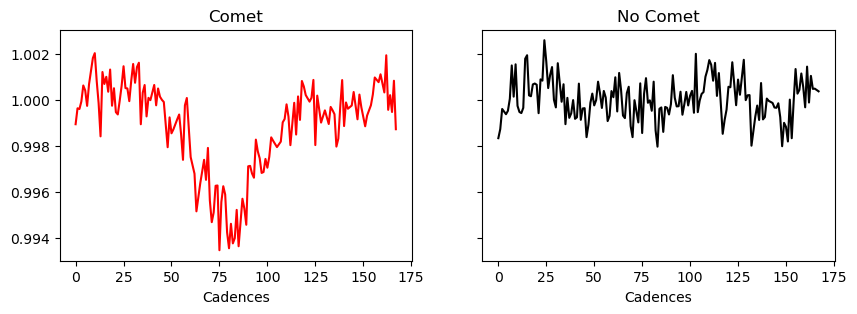

In [11]:
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[19]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[0]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

### Example of Exocomet Models

In [12]:
dsmodels = ds.train_data[ind_pc]
dsnomodels = ds.train_data[ind_nc]
# def is_minimum_in_middle(array, margin=2):
#     middle_index = array.shape[0] // 2
#     min_index = np.argmin(array)
#     return abs(min_index - middle_index) <= margin

# # Example numpy array
# arr = np.random.rand(80, 200, 1)

# # Remove arrays where the minimum point is not within 5 points of the middle
# filtered_arr = [array for array in arr if is_minimum_in_middle(array)]

# # Convert filtered_arr back to numpy array
# filtered_arr = np.array(filtered_arr)

# # Remove arrays where the minimum point is not within 5 points of the middle
# filtered_arr = [array for array in dsmodels if is_minimum_in_middle(array)]

# # Convert filtered_arr back to numpy array
# filtered_arr = np.array(filtered_arr)
# dsmodels = filtered_arr

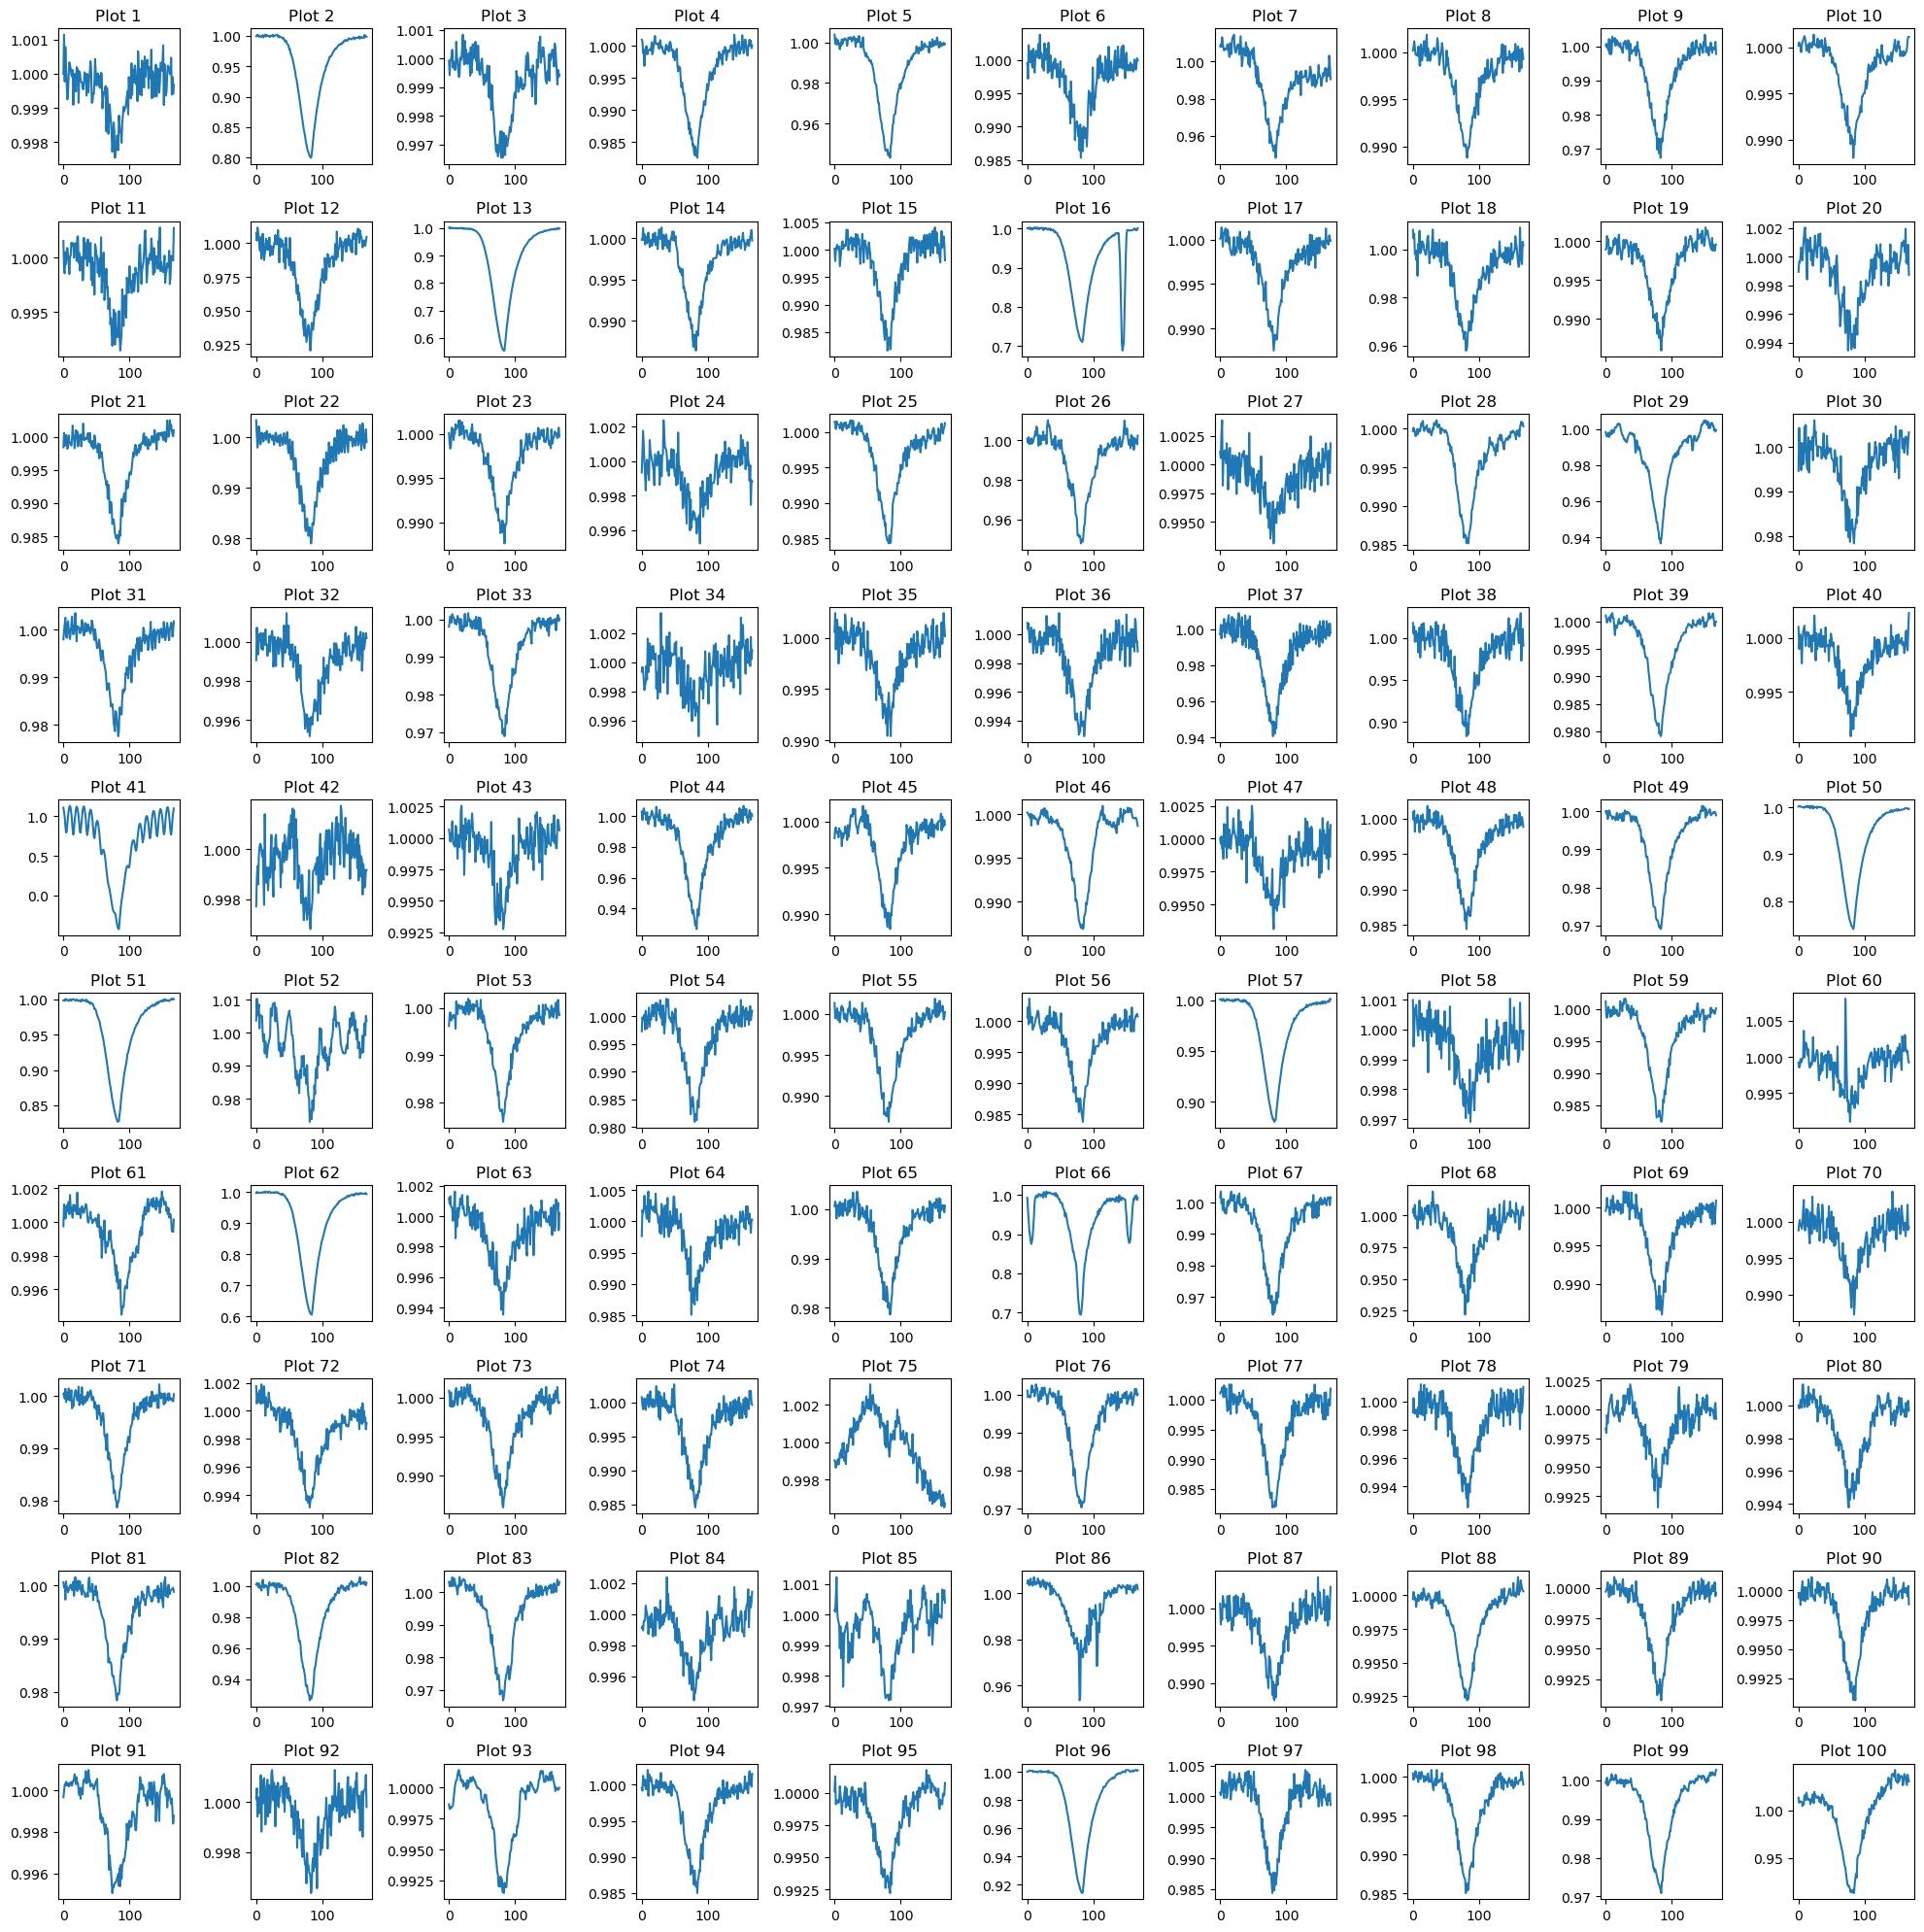

In [13]:
num_sets = dsmodels.shape[0] // 100

for set_index in range(num_sets):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig('example-models.png',dpi=200,bbox_inches='tight')
    plt.show()  # Show the grid of plots
    break

**Note**: Index is one behind plot number

In [15]:
int(ds.training_ids[ind_pc][74])

422031280

In [16]:
ds.catalog[ds.catalog['TIC'] == int(ds.training_ids[ind_pc][74])]

TIC,tpeak
int64,float64
422031280,1496.7942640252966


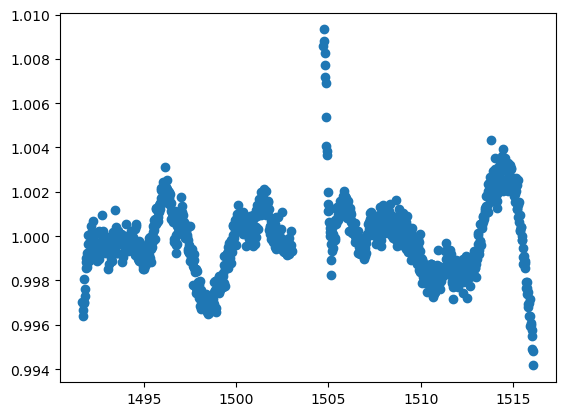

In [17]:
a = np.load('../eleanor-lite-models/422031280_sector07.npy')
plt.scatter(a[0],a[1])
#plt.scatter(a[0][a[3] == 1],a[1][a[3] == 1])


## CNN

In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
layers = [
    keras.layers.Conv1D(filters=16, kernel_size=7, activation='relu', padding='same', input_shape=(168, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.1),
    #keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    #keras.layers.MaxPooling1D(pool_size=2),
    #keras.layers.Dropout(0.1),
    #keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    #keras.layers.MaxPooling1D(pool_size=2),
    #keras.layers.Dropout(0.1),
    # keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu', padding='same'),
    # keras.layers.MaxPooling1D(pool_size=2),
    # keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
]

In [14]:
cnn = stella.ConvNN(output_dir='/Users/azib/Documents/open_source/nets2/cnn-models/',ds=ds)#,layers=layers)
SEED = 19

In [16]:
cnn.train_models(seeds=SEED, epochs=100,batch_size=256,shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 16)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 84, 16)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 84, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 84, 64)            3136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 42, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 42, 64)            0

2024-05-14 12:28:22.071197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.6933 - precision: 0.2889 - recall: 0.0027

2024-05-14 12:28:25.622831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 5s 19ms/step - loss: 0.6235 - accuracy: 0.6933 - precision: 0.2889 - recall: 0.0027 - val_loss: 0.6144 - val_accuracy: 0.6959 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
188/188 [==============================] - 3s 16ms/step - loss: 0.6165 - accuracy: 0.6945 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6143 - val_accuracy: 0.6959 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
188/188 [==============================] - 3s 17ms/step - loss: 0.6164 - accuracy: 0.6945 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6156 - val_accuracy: 0.6959 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
188/188 [==============================] - 3s 15ms/step - loss: 0.6163 - accuracy: 0.6945 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6149 - val_accuracy: 0.6959 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
188/188 [==============================]

KeyboardInterrupt: 

In [ ]:
#cnn.history_table


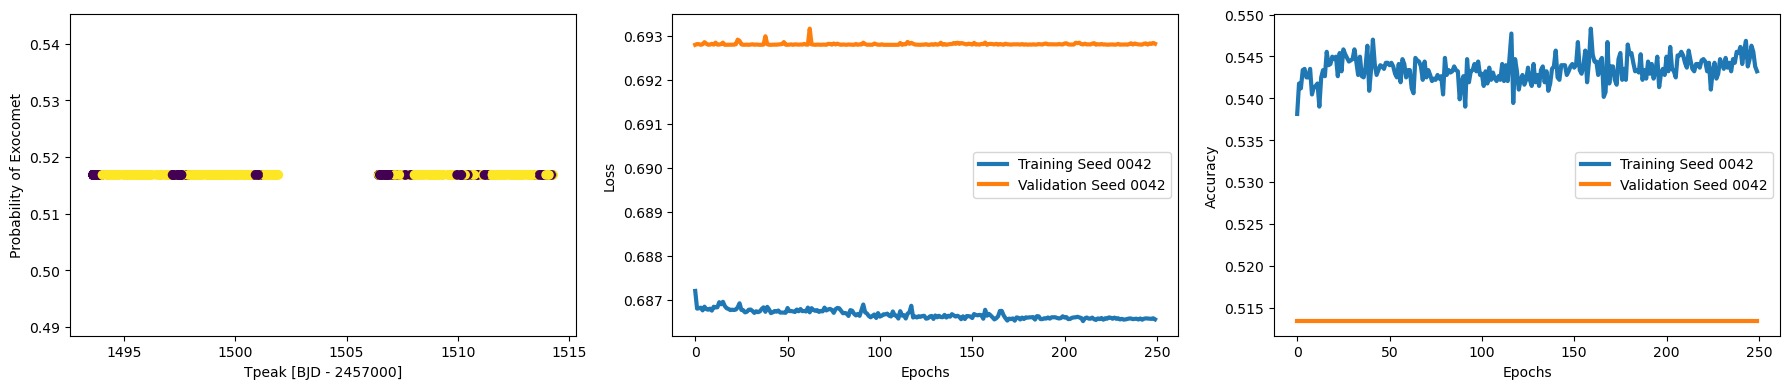

In [25]:
if type(SEED) == list:
    for seeds in SEED:
        # Create a new figure for each seed
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        
        # Format seed to have four digits with leading zeros
        formatted_seed = f'{seeds:04}'
        
        # Plot ground truth
        axes[0].scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table[f'pred_s{formatted_seed}'],
                        c=cnn.val_pred_table['gt'], vmin=0, vmax=1, label=f'Seed {formatted_seed}')
        axes[0].set_xlabel('Tpeak [BJD - 2457000]')
        axes[0].set_ylabel('Probability of Exocomet')
    
        # Plot loss
        axes[1].plot(cnn.history_table[f'loss_s{formatted_seed}'], label=f'Training Seed {formatted_seed}', lw=3)
        axes[1].plot(cnn.history_table[f'val_loss_s{formatted_seed}'], label=f'Validation Seed {formatted_seed}', lw=3)
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
    
        # Plot accuracy
        axes[2].plot(cnn.history_table[f'accuracy_s{formatted_seed}'], label=f'Training Seed {formatted_seed}', lw=3)
        axes[2].plot(cnn.history_table[f'val_accuracy_s{formatted_seed}'], label=f'Validation Seed {formatted_seed}', lw=3)
        axes[2].set_xlabel('Epochs')
        axes[2].set_ylabel('Accuracy')
        axes[2].legend()
    
        plt.tight_layout()
        plt.show()
else:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    # Format seed to have four digits with leading zeros
    formatted_seed = f'{SEED:04}'
    
    # Plot ground truth
    axes[0].scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table[f'pred_s{formatted_seed}'],
                    c=cnn.val_pred_table['gt'], vmin=0, vmax=1, label=f'Seed {formatted_seed}')
    axes[0].set_xlabel('Tpeak [BJD - 2457000]')
    axes[0].set_ylabel('Probability of Exocomet')

    # Plot loss
    axes[1].plot(cnn.history_table[f'loss_s{formatted_seed}'], label=f'Training Seed {formatted_seed}', lw=3)
    axes[1].plot(cnn.history_table[f'val_loss_s{formatted_seed}'], label=f'Validation Seed {formatted_seed}', lw=3)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Plot accuracy
    axes[2].plot(cnn.history_table[f'accuracy_s{formatted_seed}'], label=f'Training Seed {formatted_seed}', lw=3)
    axes[2].plot(cnn.history_table[f'val_accuracy_s{formatted_seed}'], label=f'Validation Seed {formatted_seed}', lw=3)
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
    


### Injecting two signals to test recovery

In [79]:
lcpath = random.choice(files)
lc, lc_info = import_lightcurve(f'{lcpath}')
#random_snr = np.random.uniform(min_snr,max_snr)
flat_flux = wotan.flatten(lc['TIME'], lc['PCA_FLUX'], method='median', window_length=1)
rms = np.std(flat_flux)
A = rms * 10

#     # Initialize a flag to indicate whether a valid time has been found
# valid_time_found = False

# while not valid_time_found:
#     t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])

#     # Check if the current random start time falls within any large gap or within 1.5 days before or after a gap
#     for index in large_gaps_indices:
#         start_time = lc['TIME'][index] - 1
#         end_time = lc['TIME'][index + 1] + 1
#         if start_time <= t0 <= end_time:
#             # Current random start time falls within a data gap or within 1.5 days before or after a gap, select a new one
#             break
#         elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
#             # Current random start time is within 1.5 days after a data gap, select a new one
#             break
#         elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
#             # Current random start time is within 1.5 days before a data gap, select a new one
#             break
#         elif t0 <= lc['TIME'][0] + 1:
#             # Current random start time is within one day after the beginning of the lightcurve, select a new one
#             break
#         elif t0 >= lc['TIME'][-1] - 2:
#             # Current random start time is within two days before the end of the lightcurve, select a new one
#             break
#     else:
#         # Current random start time doesn't fall within any data gap, 1.5 days before or after a gap, or special conditions, set the flag to True
#         valid_time_found = True

t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])
model = 1 - models.comet_curve(lc['TIME'], A, t0)
lc['PCA_FLUX'] = model * lc['PCA_FLUX']

B = rms * 2
model2 = 1 - models.comet_curve(lc['TIME'], B, 2080)
lc['PCA_FLUX'] = model2 * lc['PCA_FLUX']


In [80]:
cnn.predict(modelname='/Users/azib/Documents/open_source/nets2/cnn-models/ensemble_s0042_i0250_b0.73.h5',
            times=lc['TIME'],
            fluxes=lc['PCA_FLUX'],
            errs=lc['FLUX_ERR'])

  0%|                                                                                     | 0/1 [00:00<?, ?it/s]

23/32 [====================>.........] - ETA: 0s

2024-05-10 22:58:07.758009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Text(0, 0.5, 'Normalized Flux')

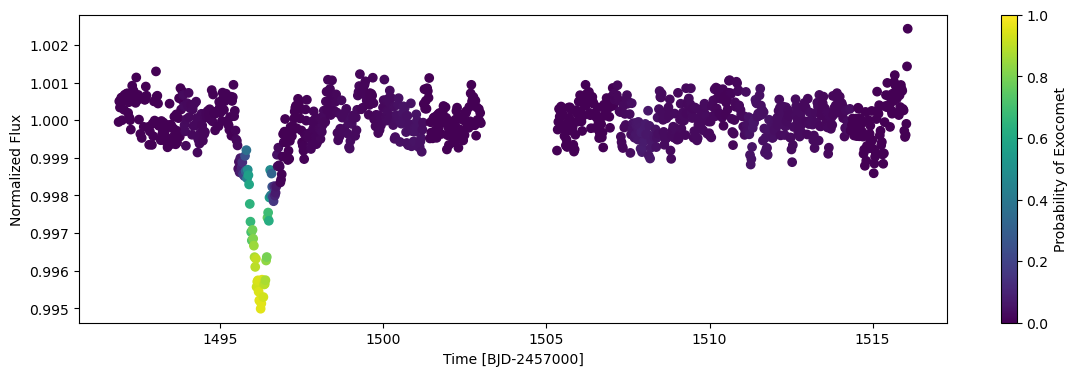

In [81]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Exocomet')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
#plt.title('TIC {}'.format(lc.targetid));

Promising, but still more to do.

---

### Trying trasnsit with exoplanet model injected in

In [41]:
import batman

In [42]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 5                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

time_diff = np.median(np.diff(lc['TIME']))
num_cadences = 450

# Calculate the total time spanned by the cadences
total_time = num_cadences * time_diff

# Calculate the start time such that the transit is centered
start_time = -total_time / 2

# Create an array of time points centered around the transit
t = np.arange(start_time, start_time + total_time, time_diff)



#t = np.arange(-1, 1 + num_cadences * time_diff, time_diff) #np.linspace(-0.025, 0.025, 500)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)

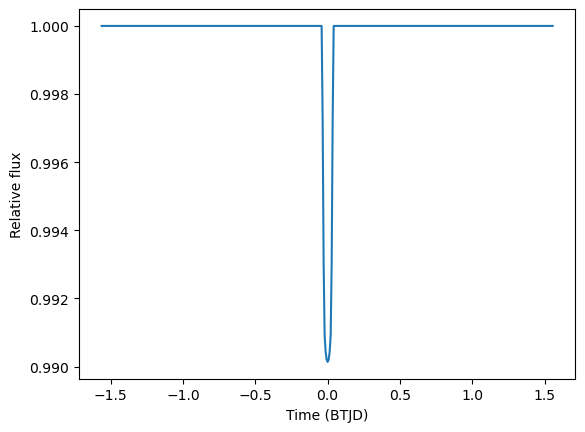

In [43]:
plt.plot(t, flux)
plt.xlabel("Time (BTJD)")
plt.ylabel("Relative flux")
plt.show()

In [44]:
#### inject the transit into a specific point in the lightcurve
lc['SAP_FLUX'] = lc['SAP_FLUX']/np.nanmedian(lc['SAP_FLUX'])
lc['SAP_FLUX'][200:650] = flux * lc[200:650]['SAP_FLUX']


# Extract the values from the smaller column
replacement_values = flux * lc[200:650]['SAP_FLUX']/np.nanmedian(lc['SAP_FLUX'])

# Replace the values in the larger column with the extracted values
lc['SAP_FLUX'][200:650] = replacement_values


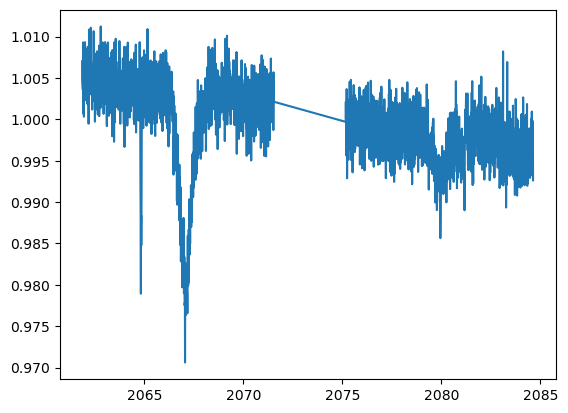

In [45]:
plt.plot(lc['TIME'],lc['SAP_FLUX'])

In [57]:
cnn.predict(modelname='/Users/azib/Documents/open_source/nets2/cnn-models/ensemble_s0042_i0100_b0.73.h5',
            times=lc['TIME'],
            fluxes=lc['SAP_FLUX'],
            errs=lc['SAP_FLUX_ERR'])

  0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

33/86 [==========>...................] - ETA: 0s

2024-05-01 16:26:44.862223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 0s 3ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


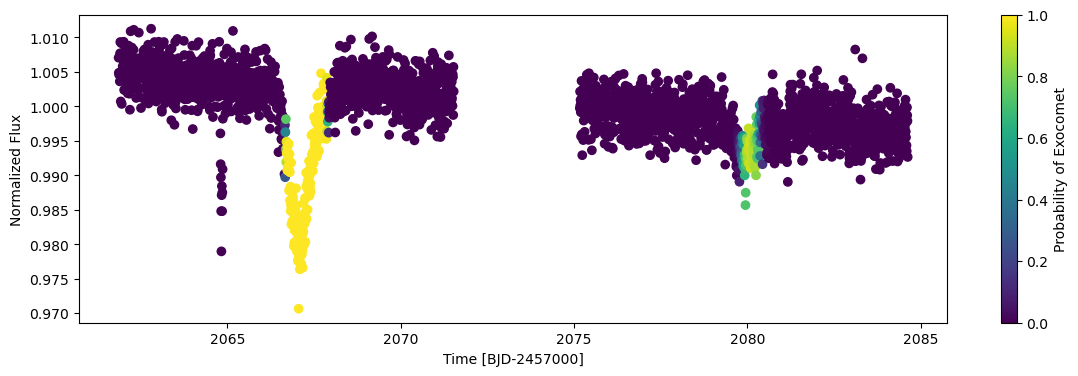

In [60]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Exocomet')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.savefig('tests.png',dpi=300,bbox_inches='tight')
#plt.title('TIC {}'.format(lc.targetid));

---

In [330]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 5                        #orbital period
params.rp = 0.4                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

time_diff = np.median(np.diff(lc['TIME']))
num_cadences = 450

# Calculate the total time spanned by the cadences
total_time = num_cadences * time_diff

# Calculate the start time such that the transit is centered
start_time = -total_time / 2

# Create an array of time points centered around the transit
t = np.arange(start_time, start_time + total_time, time_diff)



#t = np.arange(-1, 1 + num_cadences * time_diff, time_diff) #np.linspace(-0.025, 0.025, 500)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)

In [331]:
#### inject the transit into a specific point in the lightcurve
lc['SAP_FLUX'] = lc['SAP_FLUX']/np.nanmedian(lc['SAP_FLUX'])
lc['SAP_FLUX'][200:650] = flux * lc[200:650]['SAP_FLUX']

In [332]:

# Extract the values from the smaller column
replacement_values = flux * lc[200:650]['SAP_FLUX']/np.nanmedian(lc['SAP_FLUX'])

# Replace the values in the larger column with the extracted values
lc['SAP_FLUX'][200:650] = replacement_values


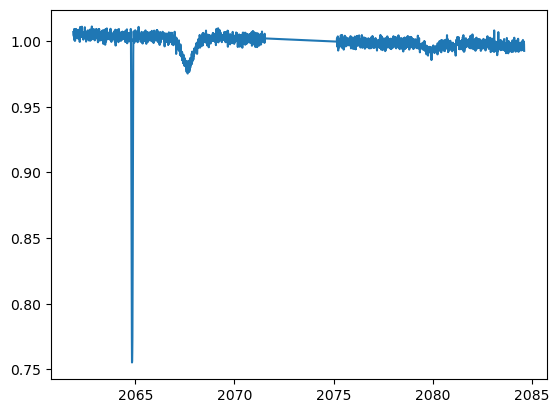

In [333]:
plt.plot(lc['TIME'],lc['SAP_FLUX'])

In [334]:
cnn.predict(modelname='/Users/azib/Documents/open_source/nets2/cnn-models/ensemble_s0042_i0100_b0.73.h5',
            times=lc['TIME'],
            fluxes=lc['SAP_FLUX'],
            errs=lc['SAP_FLUX_ERR'])

  0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]2024-05-01 14:06:08.472985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 1s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Text(0, 0.5, 'Normalized Flux')

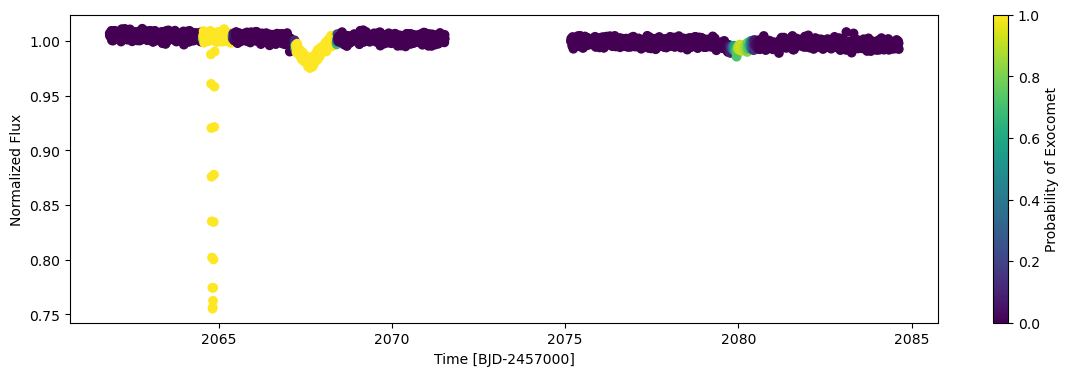

In [335]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Exocomet')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
#plt.title('TIC {}'.format(lc.targetid));